# Data Analysis in Ruby

## Introduction

This is an example of a data analysis in Ruby using [`daru`](https://github.com/v0dro/daru) to organize and manipulate data, [`mixed_models`](https://github.com/agisga/mixed_models) to fit a statistical model, and [`gnuplotrb`](https://github.com/dilcom/gnuplotrb) for visualization.

We will analyze [these data](http://archive.ics.uci.edu/ml/datasets/BlogFeedback)<sup>1</sup> from the UCI machine learning repository<sup>2</sup>, which originate from blog posts from various sources in 2010-2012.

Here, we use the data to investigate the following question:

> *If a blog post has received a comment in the first 24 hours after publication, how many more comments will it receive before 24 hours after its publication have passed?*

After doing the entire data cleaning and preprocessing with `daru`, we use `mixed_models` to fit a linear mixed model. The fitted model can be used to make predictions for future observations, and make inferences about the relationships between different variables in the data.

------------------------------------------------------------------------

[1] For more information on the data set we refer to: Buza, K. (2014). *Feedback Prediction for Blogs*. In Data Analysis, Machine Learning and Knowledge Discovery (pp. 145-152). Springer International Publishing.

[2] Lichman, M. (2013). *UCI Machine Learning Repository* <http://archive.ics.uci.edu/ml>. Irvine, CA: University of California, School of Information and Computer Science.

## Data preprocessing with `daru`

Since `daru` requires CSV files to have a header line, we add a header to the data file and save the new data frame.

In [1]:
without_header = '../examples/data/blogData_train.csv'
with_header = '../examples/data/blogData_train_with_header.csv'
colnames = (1..281).to_a.map { |x| "v#{x}" }
header = colnames.join(',')
File.open(with_header, 'w') do |fo|
  fo.puts header
  File.foreach(without_header) do |li|
    fo.puts li
  end
end

Now we can load the data with `daru`:

In [2]:
require 'daru'
df = Daru::DataFrame.from_csv '../examples/data/blogData_train_with_header.csv'
puts "Number of rows: #{df.nrows}"
puts "Number of columns: #{df.ncols}"

"if(window['d3'] === undefined ||\n   window['Nyaplot'] === undefined){\n    var path = {\"d3\":\"http://d3js.org/d3.v3.min\",\"downloadable\":\"http://cdn.rawgit.com/domitry/d3-downloadable/master/d3-downloadable\"};\n\n\n\n    var shim = {\"d3\":{\"exports\":\"d3\"},\"downloadable\":{\"exports\":\"downloadable\"}};\n\n    require.config({paths: path, shim:shim});\n\n\nrequire(['d3'], function(d3){window['d3']=d3;console.log('finished loading d3');require(['downloadable'], function(downloadable){window['downloadable']=downloadable;console.log('finished loading downloadable');\n\n\tvar script = d3.select(\"head\")\n\t    .append(\"script\")\n\t    .attr(\"src\", \"http://cdn.rawgit.com/domitry/Nyaplotjs/master/release/nyaplot.js\")\n\t    .attr(\"async\", true);\n\n\tscript[0][0].onload = script[0][0].onreadystatechange = function(){\n\n\n\t    var event = document.createEvent(\"HTMLEvents\");\n\t    event.initEvent(\"load_nyaplot\",false,false);\n\t    window.dispatchEvent(event);\n\t

Number of rows: 52397
Number of columns: 281


#### Selecting and renaming data columns

We don't want to keep most of the variables for further analysis, as the great majority of the columns represent bag-of-words features and summary statistics for other attributes.
So, we select the data columns which we want to keep, and assign them meaningful names.

In [3]:
# select a subset of columns of the data frame
keep = [:v16, :v41, :v54, :v62, :v270, :v271, :v272, 
        :v273, :v274, :v275, :v276, :v277, :v280]
blog_data = df[*keep]
df = nil

# assign meaningful names for the selected columns
meaningful_names = [:host_comments_avg, :host_trackbacks_avg, 
                    :comments, :length, :mo, :tu, :we, :th, 
                    :fr, :sa, :su, :parents, :parents_comments]
blog_data.vectors = Daru::Index.new(meaningful_names)

# the resulting data set
blog_data.head

,host_comments_avg,host_trackbacks_avg,comments,length,mo,tu,we,th,fr,sa,su,parents,parents_comments
0,34.567566,0.972973,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,34.567566,0.972973,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,34.567566,0.972973,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,34.567566,0.972973,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,34.567566,0.972973,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,34.567566,0.972973,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,34.567566,0.972973,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,34.567566,0.972973,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,34.567566,0.972973,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,34.567566,0.972973,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#### Selecting a subset of the data rows

As can be seen in the above output, the length of the text in a blog post is often given as zero. Those are probably missing values, and we get rid of the corresponding observations. 

We also delete observation which have zero comments in the first 24 hours after publication, to comply with our research objective stated in the beginning.

In [4]:
nonzero_ind = blog_data[:length].each_index.select do |i| 
  blog_data[:length][i] > 0 && blog_data[:comments][i] > 0
end
blog_data = blog_data.row[*nonzero_ind]
puts "Remaining number of rows: #{blog_data.nrows}"

Remaining number of rows: 22435


#### Replacing and transforming variables

##### Creating a categorical "day" variable

For a more clear representation of the data, and in order to use the day of the week as a grouping variable for the observations, we replace the respective seven 0-1-valued columns with one column of categorical data (with values 'mo', 'tu', 'we', 'th', 'fr', 'sa', 'su').

In [5]:
days = Array.new(blog_data.nrows) { :unknown }
[:mo, :tu, :we, :th, :fr, :sa, :su].each do |d|
  ind = blog_data[d].to_a.each_index.select { |i| blog_data[d][i]==1 }
  ind.each { |i| days[i] = d.to_s }
  blog_data.delete_vector(d)
end
blog_data[:day] = days
blog_data.head 3

,host_comments_avg,host_trackbacks_avg,comments,length,parents,parents_comments,day
1221,110.30087,0.0,74.0,3501.0,0.0,0.0,we
1222,110.30087,0.0,74.0,3501.0,0.0,0.0,we
1223,110.30087,0.0,218.0,4324.0,0.0,0.0,th


##### Replacing two highly correlated variables

The variable `parents` denotes the number of parent blog posts, where we consider a blog post P as a
parent of blog post B if B is a reply (trackback) to blog post P. 
Related to it, the variable `parents_comments` denotes the number of comments that the parents of a blog post received on average
Clearly, the two variables are highly correlated (as zero `parents` implies zero `parents_comments`). Therefore, we shouldn't include both these variables in the linear mixed model.

We combine the variables `parents` and `parents_comments` into one variable called `has_parent_with_comments`, which is a categorical variable designating whether a blog post has at least one parent post with at least one comment.

In [6]:
# create a binary indicator vector specifying if a blog post has at least 
# one parent post which has comments
hpwc = (blog_data[:parents] * blog_data[:parents_comments]).to_a
blog_data[:has_parent_with_comments] = hpwc.map { |t| t == 0 ? 'no' : 'yes'} 
blog_data.delete_vector(:parents)
blog_data.delete_vector(:parents_comments)
blog_data.head 3

,host_comments_avg,host_trackbacks_avg,comments,length,day,has_parent_with_comments
1221,110.30087,0.0,74.0,3501.0,we,no
1222,110.30087,0.0,74.0,3501.0,we,no
1223,110.30087,0.0,218.0,4324.0,th,no


##### Log transforms

Some prior experimentation with the data suggests that it is necessary to take $log$-transforms of the response variable `comments` and the predictor variable `host_comments_avg`.
This results in a much better agreement with the normality assumption on the model residuals.

In [7]:
log_comments = blog_data[:comments].to_a.map { |c| Math::log(c) }
log_host_comments_avg = blog_data[:host_comments_avg].to_a.map { |c| Math::log(c) }
blog_data[:log_comments] = log_comments
blog_data[:log_host_comments_avg] = log_host_comments_avg
blog_data.head 3

,host_comments_avg,host_trackbacks_avg,comments,length,day,has_parent_with_comments,log_comments,log_host_comments_avg
1221,110.30087,0.0,74.0,3501.0,we,no,4.30406509320417,4.7032118138076795
1222,110.30087,0.0,74.0,3501.0,we,no,4.30406509320417,4.7032118138076795
1223,110.30087,0.0,218.0,4324.0,th,no,5.384495062789089,4.7032118138076795


## Linear mixed model

The logarithm of the number of comments of a given blog post is modeled as a function of the blog post text length, the average number of comments and trackbacks per blog article at the hosting website of the blog, and the existence of commented parent blog posts. Additionally, we model random fluctuations of the number of comments due to the day of the week when the blog post was released.

That is, the number of comments of the $i$th blog post, which is published on weekday $d$, is estimated as

$$log(comments_i) \approx \beta_0 + length_i \cdot \beta_1 + log(host\_comments_i) \cdot \beta_2 + host\_trackbacks_i \cdot \beta_3 + parent\_with\_comments\_yes \cdot \beta_4 + b_d.$$

*Note:* It is questionable whether a linear mixed model is a good choice here, because the response variable represents count data, which for obvious reasons cannot follow a normal distribution. However, we can still get a reasonble model fit, and certainly gain some insight into the data from the linear mixed model, even if it wont match the data very well. In fact, by taking the $log$-transform, we partially account for the fact that the response variable represents count data.

We fit the model with `mixed_models` and display the estimated fixed effects coefficients (the $\beta$'s from the above equation).

In [8]:
require 'mixed_models'
model_fit = LMM.from_formula(formula: "log_comments ~ log_host_comments_avg + host_trackbacks_avg + length + has_parent_with_comments + (1 | day)", data: blog_data)
model_fit.fix_ef

{:intercept=>1.2847896684307731, :log_host_comments_avg=>0.415586319225577, :host_trackbacks_avg=>-0.07551588997745964, :length=>1.8245853808280765e-05, :has_parent_with_comments_lvl_yes=>-0.4616662830553772}

### Assess the quality of the fit

##### Fitted vs. residuals plot

We can assess the goodness of the model fit (to some extent) by plotting the residuals agains the fitted values. We definately see a pattern here -- the model seems to make somewhat better predictions for observations with a small number of comments. Additionally, a subset of the observations displays what appears to be a linear relationship between the fitted values and the residuals, which is a reason for concern. However, this is due to the fact the the response variable has a discrete range ($log$ transfrom of count data), with possible values at the low end being especially far apart.

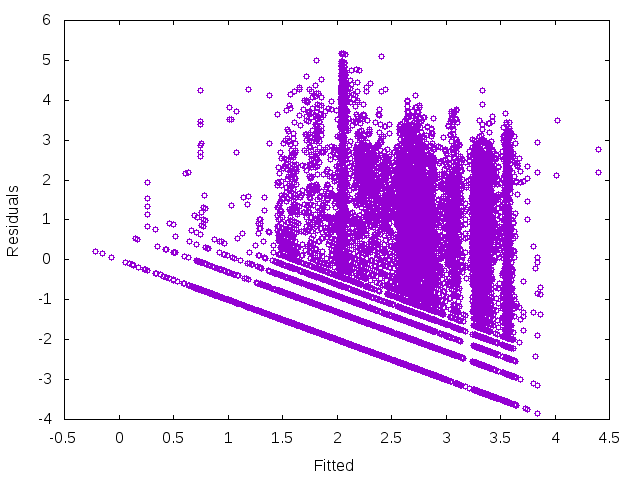

In [9]:
require 'gnuplotrb'
include GnuplotRB

x, y = model_fit.fitted, model_fit.residuals
fitted_vs_residuals = Plot.new([[x,y], with: 'points', pointtype: 6, notitle: true],
                               xlabel: 'Fitted', ylabel: 'Residuals')
fitted_vs_residuals.term('png')

##### Histogram of the residuals

We can further analyze the validity of the linear mixed model somewhat, by looking at a histogram and checking if the residuals appear to be approximately normally distributed.
The distribution looks a little right skewd and heavy-tailed, but in general not too different from a bell-shaped normal curve.

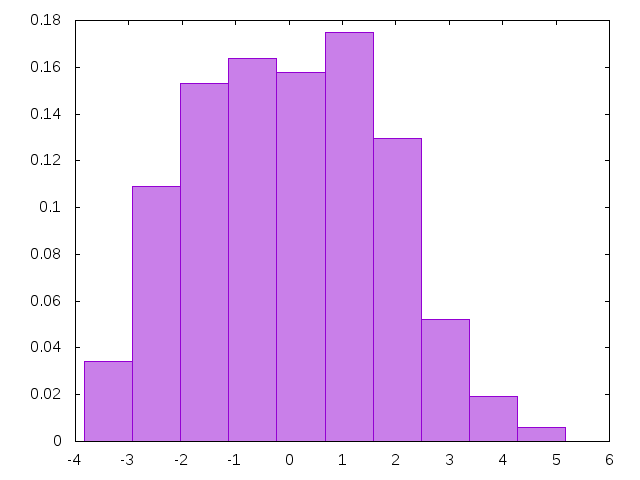

In [10]:
bin_width = (y.max - y.min)/10.0
bins = (y.min..y.max).step(bin_width).to_a
rel_freq = Array.new(bins.length-1){0.0}
y.each do |r|
  0.upto(bins.length-2) do |i|
    if r >= bins[i] && r < bins[i+1] then
      rel_freq[i] += 1.0/y.length
    end
  end
end
bins_center = bins[0...-1].map { |b| b + bin_width/2.0 }
  
residuals_hist = Plot.new([[bins_center, rel_freq], with: 'boxes', notitle: true],
                           style: 'fill solid 0.5')
residuals_hist.term('png')

##### Q-Q plot of the residuals

The Q-Q scatter plot deviates quite a lot at both ends from the diagonal. However, it isn't horrible considering that we are modeling count data with a normal distribution.

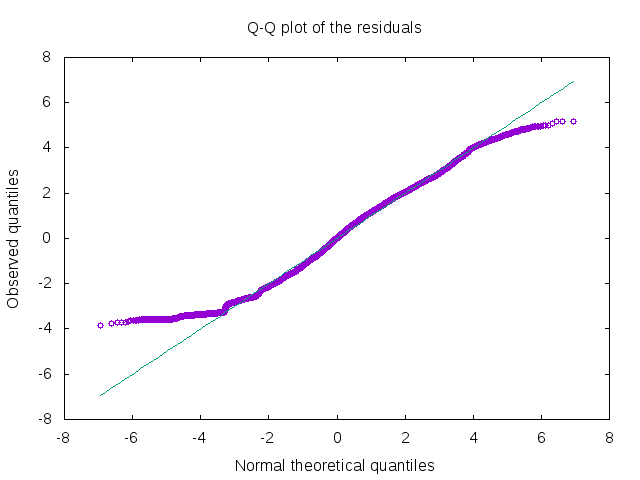

In [11]:
require 'distribution'

observed = model_fit.residuals.sort
n = observed.length
theoretical = (1..n).to_a.map { |t| Distribution::Normal.p_value(t.to_f/n.to_f) * model_fit.sigma}
qq_plot = Plot.new([[theoretical, observed], with: 'points', pointtype: 6, notitle: true],
                   ['x', with: 'lines', notitle: true],
                   xlabel: 'Normal theoretical quantiles', ylabel: 'Observed quantiles',
                   title: 'Q-Q plot of the residuals')
qq_plot.term('png')

In general, we see that even though the model residuals satisfy the normality assumption to some extent, it is quite far from being perfect. Therefore, we should proceed with caution in the further interpretation of the results.

### Estimation results

Let's look at the estimated model parameters, and see what they reveal about the data.

##### Fixed effects

Looking at the fixed effects coefficients it is striking that the estimate corresponding to the effect of the blog post text length is almost zero. Possibly, the length of a blog post has practically no effect on how many comments the blog post will receive.

In [14]:
puts "Obtained fixed effects coefficient estimates:"
puts model_fit.fix_ef

Obtained fixed effects coefficient estimates:
{:intercept=>1.2847896684307731, :log_host_comments_avg=>0.415586319225577, :host_trackbacks_avg=>-0.07551588997745964, :length=>1.8245853808280765e-05, :has_parent_with_comments_lvl_yes=>-0.4616662830553772}


The directionality of the obtained estimates implies that blog posts hosted on websites with a high average of comments per blog post, also tend to have more comments. Moreover, blog posts which have parent blog posts, tend to have fewer comments. 
The effects of the average number of trackbacks per blog post on the hosting website and the blog post length seem rather small in magnitude.

Based on the [Wald Z test statistics](https://en.wikipedia.org/wiki/Wald_test#Test_on_a_single_parameter), we can carry out hypotheses tests for each fixed effects terms $\beta_{i}$, testing the null $H_{0} : \beta_{i} = 0$ against the alternative $H_{a} : \beta_{i} \neq 0$.

*Note:* The Wald methods for $p$-values and confidence intervals are not absolutely trustworthy and should be treated with caution, as pointed out in [this blog post](http://agisga.github.io/MixedModels_p_values_and_CI/).

The corresponding (approximate) p-values are obtained with:

In [15]:
model_fit.fix_ef_p(method: :wald)

{:intercept=>0.0, :log_host_comments_avg=>0.0, :host_trackbacks_avg=>4.575895218295045e-12, :length=>9.391631916599863e-10, :has_parent_with_comments_lvl_yes=>0.0009244972814528296}

Interestingly, all $p$-values are tiny, implying that each predictor has a very strong linear relationship with the response variable.

However, we should be careful with our conclusions. The very small $p$-values can also be explained by the large sample size (>20000 observations).

We can also look at Wald confidence intervals for the fixed effects coefficient estimates, which are in general more informative than $p$-values.

In [16]:
conf_int = model_fit.fix_ef_conf_int(level: 0.95, method: :wald)
ci = Daru::DataFrame.rows(conf_int.values, order: [:lower95, :upper95], index: model_fit.fix_ef_names)
ci[:coef] = model_fit.fix_ef.values
ci

,lower95,upper95,coef
intercept,1.2252448213288285,1.3443345155327178,1.2847896684307731
log_host_comments_avg,0.40020379911986,0.430968839331294,0.415586319225577
host_trackbacks_avg,-0.09691011956173742,-0.05412166039318187,-0.07551588997745964
length,1.240196435580648e-05,2.4089743260755053e-05,1.8245853808280765e-05
has_parent_with_comments_lvl_yes,-0.7348242412166397,-0.1885083248941148,-0.4616662830553772


We observe that none of the 95% confidence intervals contains 0, which suggest high statistical significance of the linear predictors (equivalent to $p$-values). Also, all of the intervals seem rather narrow.

##### Random effects

We can look at the obtained random effects estimates (the values $b_d$ from the above equation, where $d\in\{mo, tu, we, th, fr, sa, su\}$).

In [17]:
puts "Obtained random effects coefficient estimates:"
puts model_fit.ran_ef

Obtained random effects coefficient estimates:
{:intercept_fr=>0.0, :intercept_mo=>0.0, :intercept_sa=>0.0, :intercept_su=>0.0, :intercept_th=>0.0, :intercept_tu=>0.0, :intercept_we=>0.0}


In [18]:
puts "Random effects variance:"
puts model_fit.sigma_mat[0,0]

Random effects variance:
0.0


Interestingly, the estimates of the random effects coefficients and variance are all zero!

That is, we have a singular fit. Thus, our results imply that the variability between different days of the week is not large enough to justify non-zero random effects in this model. Practically, we can coclude that the day of the week on which a blog post is published has no effect on the number of comments that the blog post will receive in the first 24 hours.

## Conclusions

This turned out to be an example of a degenerate model fit (random effects variance estimated to be zero), and we saw that `mixed_models` can handle degenerate fits very well. 

Of course we learned alot about the blog post data by doing this analysis. Here is a list of some of the findings.

* Blog posts hosted on websites with a high average of comments per blog post, also tend to have more comments (obviously). 

* Blog posts which have parent blog posts, seem to have fewer comments (wonder why that is...).

* The effect of the average number of trackbacks per blog post on the hosting website seems to have a very small effect on the number of comments of a given blog post. However, the effect is negative.

* The blog post text length has an extremely small positive effect on the number of comments.

* All considered fixed effects predictor variables seem to have a significant influence on the number of comments that a blog post receives in the first 24 hours after publication (according to Wald Z tests).

* The day of the week on which a blog post is published has practically no influence on the number of comments that the blog post will receive in the first 24 hours after publication.